In [1]:
!pip3 install beautifulsoup4
!pip install sqlalchemy==1.3.9
!pip install ipython-sql
!pip install ipython-sql prettytable

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 37.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sqlalchemy: filename=SQLAlchemy-1.3.9-cp312-cp312-linux_x86_64.whl size=1196052 sha256=e323cea4814fe35167c5b45ca5b62819e9608dba083a253e958180c85428054b
  Stored in directory: /root/.cache/pip/wheels/b3/1c/42/0e26b8d512adc6bce10ff71a05229366b4ccec641cd3b42111
Successfully built sqlalchemy
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.43
    Uninstalling SQLAlchemy-2.0.43:
      Successfully uninstalled SQLAlchemy-2.0.43
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.3.9 which is incompatible.
langchain 0.3.27 requires SQLAlchemy<3,>=1.4, but you have sqlalchemy 1.3.9 which is incompatible.
google-adk 1.11.0 requires sq

In [2]:
import requests
import pandas as pd
import numpy as np
import datetime
import sys
from bs4 import BeautifulSoup
import re
import unicodedata
import csv, sqlite3
import prettytable
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from folium.plugins import MousePosition
from folium.features import DivIcon
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Lab1

In [3]:
def getBoosterVersion(data):
    booster_version = []
    for rocket_id in data['rocket']:
        if pd.notna(rocket_id):  # avoids NaN issues
            response = requests.get(f"https://api.spacexdata.com/v4/rockets/{rocket_id}")
            if response.status_code == 200:
                json_data = response.json()
                booster_version.append(json_data.get('name', None))
            else:
                booster_version.append(None)
        else:
            booster_version.append(None)
    return booster_version

# Example usage:
# data['BoosterVersion'] = getBoosterVersion(data)


In [4]:
def getLaunchSite(data):
    longitude_list = []
    latitude_list = []
    launchsite_list = []

    for launchpad_id in data['launchpad']:
        if pd.notna(launchpad_id):
            response = requests.get(f"https://api.spacexdata.com/v4/launchpads/{launchpad_id}")
            if response.status_code == 200:
                json_data = response.json()
                longitude_list.append(json_data.get('longitude', None))
                latitude_list.append(json_data.get('latitude', None))
                launchsite_list.append(json_data.get('name', None))
            else:
                longitude_list.append(None)
                latitude_list.append(None)
                launchsite_list.append(None)
        else:
            longitude_list.append(None)
            latitude_list.append(None)
            launchsite_list.append(None)

    return longitude_list, latitude_list, launchsite_list

# Example usage:
# data['Longitude'], data['Latitude'], data['LaunchSite'] = getLaunchSite(data)


In [5]:
def getPayloadData(data):
    payload_mass_list = []
    orbit_list = []

    for payload_id in data['payloads']:
        if pd.notna(payload_id):
            response = requests.get(f"https://api.spacexdata.com/v4/payloads/{payload_id}")
            if response.status_code == 200:
                json_data = response.json()
                payload_mass_list.append(json_data.get('mass_kg', None))
                orbit_list.append(json_data.get('orbit', None))
            else:
                payload_mass_list.append(None)
                orbit_list.append(None)
        else:
            payload_mass_list.append(None)
            orbit_list.append(None)

    return payload_mass_list, orbit_list

# Example usage:
# data['PayloadMass'], data['Orbit'] = getPayloadData(data)


In [6]:
def getCoreData(data):
    block_list = []
    reused_count_list = []
    serial_list = []
    outcome_list = []
    flights_list = []
    gridfins_list = []
    reused_list = []
    legs_list = []
    landingpad_list = []

    for core_info in data['cores']:
        if isinstance(core_info, dict):
            core_id = core_info.get('core')
        else:
            core_id = None

        # Fetch core details if core_id exists
        if pd.notna(core_id):
            response = requests.get(f"https://api.spacexdata.com/v4/cores/{core_id}")
            if response.status_code == 200:
                json_data = response.json()
                block_list.append(json_data.get('block', None))
                reused_count_list.append(json_data.get('reuse_count', None))
                serial_list.append(json_data.get('serial', None))
            else:
                block_list.append(None)
                reused_count_list.append(None)
                serial_list.append(None)
        else:
            block_list.append(None)
            reused_count_list.append(None)
            serial_list.append(None)

        # Append other fields from the local core_info dict
        outcome_list.append(f"{core_info.get('landing_success', None)} {core_info.get('landing_type', None)}")
        flights_list.append(core_info.get('flight', None))
        gridfins_list.append(core_info.get('gridfins', None))
        reused_list.append(core_info.get('reused', None))
        legs_list.append(core_info.get('legs', None))
        landingpad_list.append(core_info.get('landpad', None))

    return (block_list, reused_count_list, serial_list,
            outcome_list, flights_list, gridfins_list,
            reused_list, legs_list, landingpad_list)

# Example usage:
# (data['Block'], data['ReusedCount'], data['Serial'],
#  data['Outcome'], data['Flights'], data['GridFins'],
#  data['Reused'], data['Legs'], data['LandingPad']) = getCoreData(data)

In [7]:
spacex_url="https://api.spacexdata.com/v4/launches/past"

In [8]:
response = requests.get(spacex_url)

In [9]:
print(response.content)

b'[{"fairings":{"reused":false,"recovery_attempt":false,"recovered":false,"ships":[]},"links":{"patch":{"small":"https://images2.imgbox.com/94/f2/NN6Ph45r_o.png","large":"https://images2.imgbox.com/5b/02/QcxHUb5V_o.png"},"reddit":{"campaign":null,"launch":null,"media":null,"recovery":null},"flickr":{"small":[],"original":[]},"presskit":null,"webcast":"https://www.youtube.com/watch?v=0a_00nJ_Y88","youtube_id":"0a_00nJ_Y88","article":"https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html","wikipedia":"https://en.wikipedia.org/wiki/DemoSat"},"static_fire_date_utc":"2006-03-17T00:00:00.000Z","static_fire_date_unix":1142553600,"net":false,"window":0,"rocket":"5e9d0d95eda69955f709d1eb","success":false,"failures":[{"time":33,"altitude":null,"reason":"merlin engine failure"}],"details":"Engine failure at 33 seconds and loss of vehicle","crew":[],"ships":[],"capsules":[],"payloads":["5eb0e4b5b6c3bb0006eeb1e1"],"launchpad":"5e9e4502f5090995de566f86","flight_number":1,"name

In [10]:
static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'

In [11]:
response=requests.get(static_json_url)

In [12]:
response.status_code

200

In [13]:
data = response.json()
df = pd.json_normalize(data)

In [14]:
df['static_fire_date_utc']

,static_fire_date_utc
0,2006-03-17T00:00:00.000Z
1,None
2,None
3,2008-09-20T00:00:00.000Z
4,None
...,...
102,None
103,2020-10-17T05:23:00.000Z
104,2020-10-21T12:55:00.000Z
105,2020-09-25T05:42:00.000Z


In [15]:
data = df[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])
data['date'] = pd.to_datetime(data['date_utc']).dt.date
data = data[data['date'] <= datetime.date(2020, 11, 13)]

In [16]:
data['BoosterVersion'] = getBoosterVersion(data)

data['Longitude'], data['Latitude'], data['LaunchSite'] = getLaunchSite(data)

data['PayloadMass'], data['Orbit'] = getPayloadData(data)

(data['Block'], data['ReusedCount'], data['Serial'],
 data['Outcome'], data['Flights'], data['GridFins'],
 data['Reused'], data['Legs'], data['LandingPad']) = getCoreData(data)

In [17]:
df = data[data['BoosterVersion'] == 'Falcon 9']

In [18]:
column_df =  df.columns

In [19]:
for i in range (len(column_df)):
  print(i,column_df[i], df[column_df[i]].isna().sum())

0 rocket 0
1 payloads 0
2 launchpad 0
3 cores 0
4 flight_number 0
5 date_utc 0
6 date 0
7 BoosterVersion 0
8 Longitude 0
9 Latitude 0
10 LaunchSite 0
11 PayloadMass 5
12 Orbit 0
13 Block 0
14 ReusedCount 0
15 Serial 0
16 Outcome 0
17 Flights 0
18 GridFins 0
19 Reused 0
20 Legs 0
21 LandingPad 26


In [20]:
df['PayloadMass'].fillna(df['PayloadMass'].median(), inplace=True)

/tmp/ipython-input-2496982699.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['PayloadMass'].fillna(df['PayloadMass'].median(), inplace=True)
/tmp/ipython-input-2496982699.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PayloadMass'].fillna(df['PayloadMass'].median(), inplace=True)


In [21]:
df['LandingPad'].fillna(df['LandingPad'].mode()[0], inplace=True)

/tmp/ipython-input-971816339.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['LandingPad'].fillna(df['LandingPad'].mode()[0], inplace=True)
/tmp/ipython-input-971816339.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LandingPad'].fillna(df['LandingPad'].mode()[0], inplace=True)


In [22]:
len(df)

90

In [23]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()

    colunm_name = ' '.join(row.contents)

    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name


In [24]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

In [25]:
response= requests.get(static_url)

In [26]:
response.status_code

200

In [27]:
df_html = BeautifulSoup(response.content, "html.parser")

In [28]:
df_html.title

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>

In [29]:
html_tables = df_html.find_all('table')
print(f"Found {len(html_tables)} tables.")

Found 25 tables.


In [30]:
first_launch_table = html_tables[2]

In [31]:
column_names = []
for th in first_launch_table.find_all('th'):
    name = extract_column_from_header(th)  # Your custom function
    if name is not None and len(name) > 0:  # Only keep non-empty names
        column_names.append(name)

In [32]:
print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


In [33]:
launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

 # Lab2

In [34]:
df=pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_1.csv")
df.head(10)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857
5,6,2014-01-06,Falcon 9,3325.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1005,-80.577366,28.561857
6,7,2014-04-18,Falcon 9,2296.000000,ISS,CCAFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1006,-80.577366,28.561857
7,8,2014-07-14,Falcon 9,1316.000000,LEO,CCAFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1007,-80.577366,28.561857
8,9,2014-08-05,Falcon 9,4535.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1008,-80.577366,28.561857
9,10,2014-09-07,Falcon 9,4428.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1011,-80.577366,28.561857


In [35]:
df.isnull().sum()/len(df)*100

,0
FlightNumber,0.000000
Date,0.000000
BoosterVersion,0.000000
PayloadMass,0.000000
Orbit,0.000000
LaunchSite,0.000000
Outcome,0.000000
Flights,0.000000
GridFins,0.000000
Reused,0.000000


In [36]:
df.dtypes

,0
FlightNumber,int64
Date,object
BoosterVersion,object
PayloadMass,float64
Orbit,object
LaunchSite,object
Outcome,object
Flights,int64
GridFins,bool
Reused,bool


In [37]:
df['LaunchSite'].value_counts()

,count
LaunchSite,
CCAFS SLC 40,55
KSC LC 39A,22
VAFB SLC 4E,13


In [38]:
df['Orbit'].value_counts()

,count
Orbit,
GTO,27
ISS,21
VLEO,14
PO,9
LEO,7
SSO,5
MEO,3
HEO,1
ES-L1,1


In [39]:
landing_outcomes = df['Outcome'].value_counts()

In [40]:
landing_outcomes

,count
Outcome,
True ASDS,41
None None,19
True RTLS,14
False ASDS,6
True Ocean,5
False Ocean,2
None ASDS,2
False RTLS,1


In [41]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [42]:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

In [43]:
df['Landing_Class'] = df['Outcome'].apply(lambda x: 0 if x in bad_outcomes else 1)
df['Landing_Class']

,Landing_Class
0,0
1,0
2,0
3,0
4,0
...,...
85,1
86,1
87,1
88,1


In [44]:
df["Landing_Class"].mean()

np.float64(0.6666666666666666)

# Lab3

In [45]:
%load_ext sql
prettytable.DEFAULT = 'DEFAULT'

con = sqlite3.connect("my_data1.db")
cur = con.cursor()
%sql sqlite:///my_data1.db

In [46]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_2/data/Spacex.csv")
df.to_sql("SPACEXTBL", con, if_exists='replace', index=False,method="multi")

101

In [47]:
%sql DROP TABLE IF EXISTS SPACEXTABLE;

 * sqlite:///my_data1.db
Done.


[]

In [48]:
%sql create table SPACEXTABLE as select * from SPACEXTBL where Date is not null

 * sqlite:///my_data1.db
Done.


[]

In [49]:
%sql PRAGMA table_info(SPACEXTABLE);

 * sqlite:///my_data1.db
Done.


cid,name,type,notnull,dflt_value,pk
0,Date,TEXT,0,None,0
1,Time (UTC),TEXT,0,None,0
2,Booster_Version,TEXT,0,None,0
3,Launch_Site,TEXT,0,None,0
4,Payload,TEXT,0,None,0
5,PAYLOAD_MASS__KG_,INT,0,None,0
6,Orbit,TEXT,0,None,0
7,Customer,TEXT,0,None,0
8,Mission_Outcome,TEXT,0,None,0
9,Landing_Outcome,TEXT,0,None,0


In [50]:
%sql SELECT DISTINCT Landing_Outcome FROM SPACEXTABLE;

 * sqlite:///my_data1.db
Done.


Landing_Outcome
Failure (parachute)
No attempt
Uncontrolled (ocean)
Controlled (ocean)
Failure (drone ship)
Precluded (drone ship)
Success (ground pad)
Success (drone ship)
Success
Failure


In [51]:
%sql SELECT Launch_Site FROM SPACEXTABLE WHERE Launch_Site LIKE 'CCA%' lIMIT 5;

 * sqlite:///my_data1.db
Done.


Launch_Site
CCAFS LC-40
CCAFS LC-40
CCAFS LC-40
CCAFS LC-40
CCAFS LC-40


In [52]:
%sql SELECT SUM(PAYLOAD_MASS__KG_) AS Total_Payload_Mass FROM SPACEXTABLE WHERE Customer LIKE 'NASA (CRS)';

 * sqlite:///my_data1.db
Done.


Total_Payload_Mass
45596


In [53]:
%sql SELECT AVG(PAYLOAD_MASS__KG_) AS Average_Payload_Mass FROM SPACEXTABLE WHERE Booster_Version LIKE 'F9 v1.1';

 * sqlite:///my_data1.db
Done.


Average_Payload_Mass
2928.4


In [54]:
%sql SELECT MIN(Date) AS First_Success_Date FROM SPACEXTABLE WHERE Landing_Outcome LIKE 'Success (ground pad)';

 * sqlite:///my_data1.db
Done.


First_Success_Date
2015-12-22


In [55]:
%sql SELECT Booster_Version FROM SPACEXTABLE WHERE Landing_Outcome LIKE 'Success (drone ship)' AND PAYLOAD_MASS__KG_ BETWEEN 4000 AND 6000;

 * sqlite:///my_data1.db
Done.


Booster_Version
F9 FT B1022
F9 FT B1026
F9 FT B1021.2
F9 FT B1031.2


In [56]:
%sql SELECT Landing_Outcome, COUNT(*) AS Count FROM SPACEXTABLE WHERE DATE BETWEEN '2010-06-04' AND '2017-03-20' GROUP BY Landing_Outcome ORDER BY Count DESC;

 * sqlite:///my_data1.db
Done.


Landing_Outcome,Count
No attempt,10
Success (drone ship),5
Failure (drone ship),5
Success (ground pad),3
Controlled (ocean),3
Uncontrolled (ocean),2
Failure (parachute),2
Precluded (drone ship),1


In [57]:
%sql SELECT DISTINCT Booster_Version FROM SPACEXTABLE WHERE PAYLOAD_MASS__KG_ = (SELECT MAX(PAYLOAD_MASS__KG_) FROM SPACEXTABLE);

 * sqlite:///my_data1.db
Done.


Booster_Version
F9 B5 B1048.4
F9 B5 B1049.4
F9 B5 B1051.3
F9 B5 B1056.4
F9 B5 B1048.5
F9 B5 B1051.4
F9 B5 B1049.5
F9 B5 B1060.2
F9 B5 B1058.3
F9 B5 B1051.6


In [58]:
%%sql SELECT
        substr(Date, 6, 2) AS Month,     -- extracts MM
        Landing_Outcome,
        Booster_Version,
        Launch_Site
FROM SPACEXTABLE
WHERE substr(Date, 1, 4) = '2015'       -- Year = 2015
  AND Landing_Outcome NOT LIKE 'Success%'
  AND Landing_Outcome LIKE '%drone ship%';


 * sqlite:///my_data1.db
Done.


Month,Landing_Outcome,Booster_Version,Launch_Site
01,Failure (drone ship),F9 v1.1 B1012,CCAFS LC-40
04,Failure (drone ship),F9 v1.1 B1015,CCAFS LC-40
06,Precluded (drone ship),F9 v1.1 B1018,CCAFS LC-40


In [59]:
%sql SELECT DISTINCT Launch_Site from SPACEXTABLE

 * sqlite:///my_data1.db
Done.


Launch_Site
CCAFS LC-40
VAFB SLC-4E
KSC LC-39A
CCAFS SLC-40


In [60]:
con.close()

# Lab4

In [61]:
URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
df = pd.read_csv(URL)

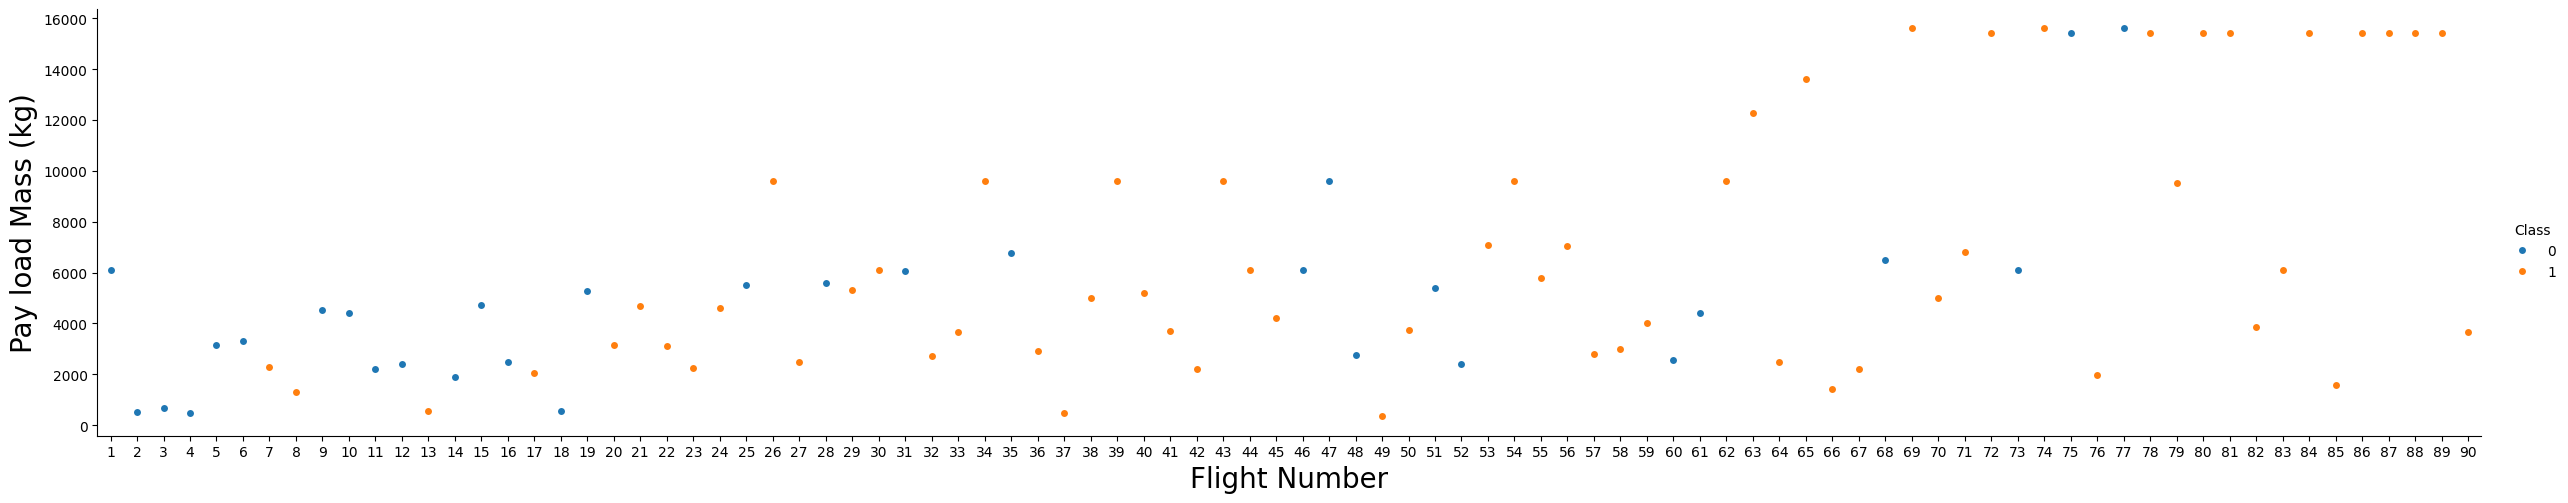

In [62]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

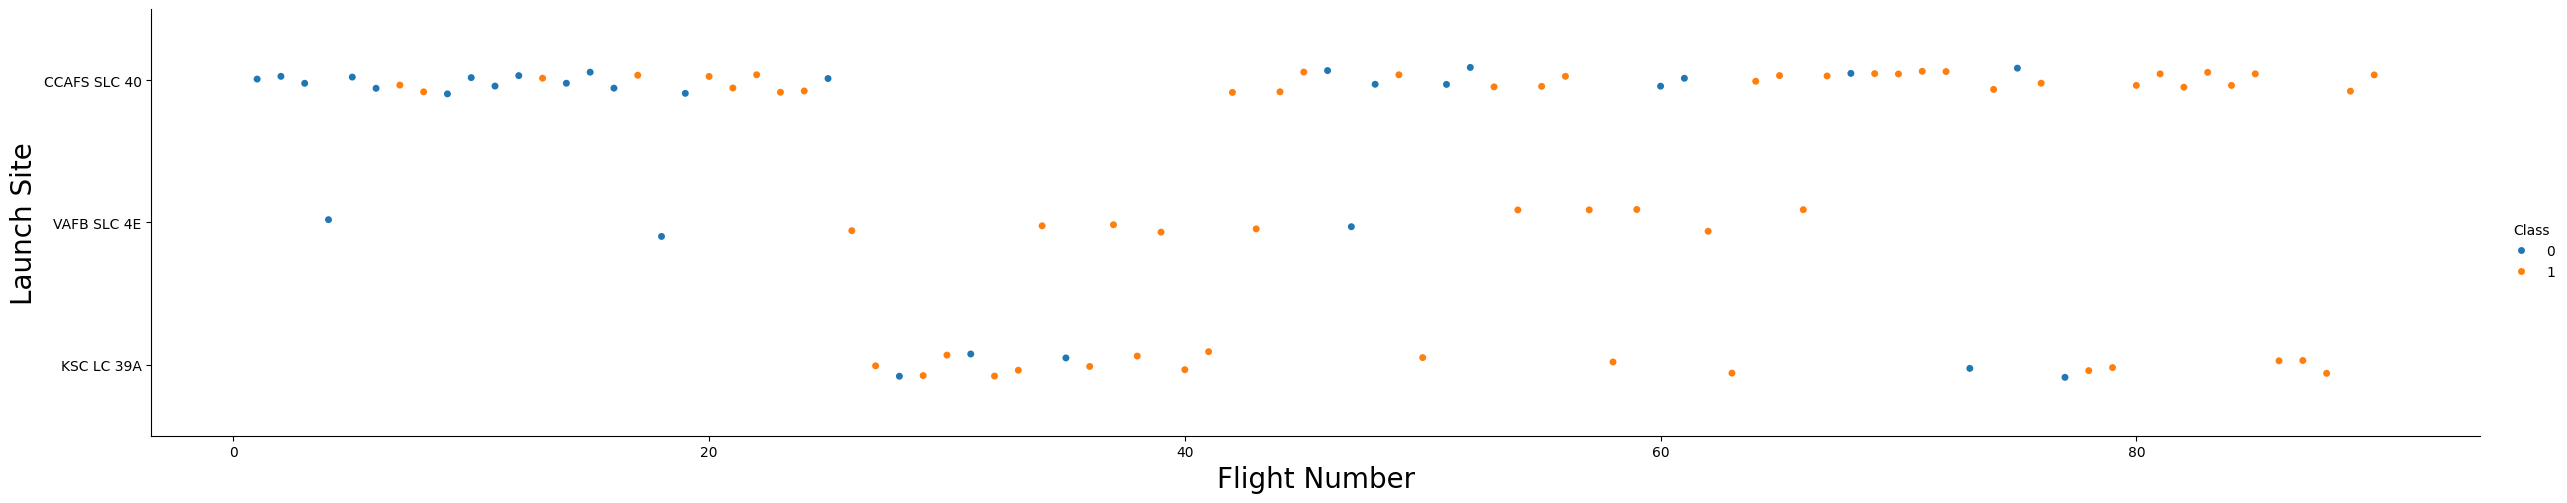

In [63]:
sns.catplot(y="LaunchSite", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Launch Site",fontsize=20)
plt.show()

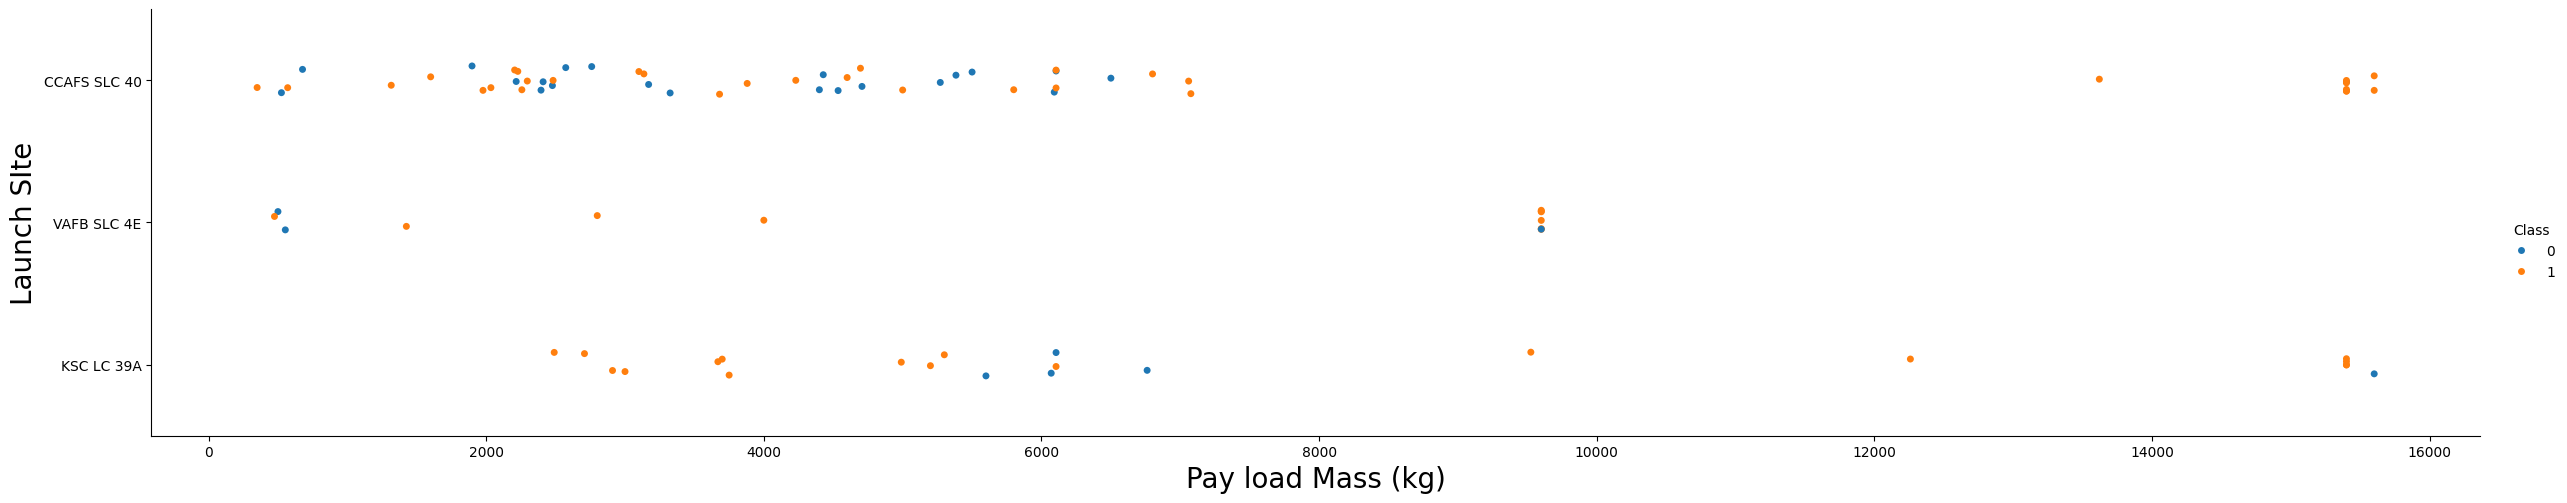

In [64]:
sns.catplot(y="LaunchSite", x="PayloadMass", hue="Class", data=df, aspect = 5)
plt.ylabel("Launch SIte",fontsize=20)
plt.xlabel("Pay load Mass (kg)",fontsize=20)
plt.show()

In [65]:
df.columns

Index(['FlightNumber', 'Date', 'BoosterVersion', 'PayloadMass', 'Orbit',
       'LaunchSite', 'Outcome', 'Flights', 'GridFins', 'Reused', 'Legs',
       'LandingPad', 'Block', 'ReusedCount', 'Serial', 'Longitude', 'Latitude',
       'Class'],
      dtype='object')

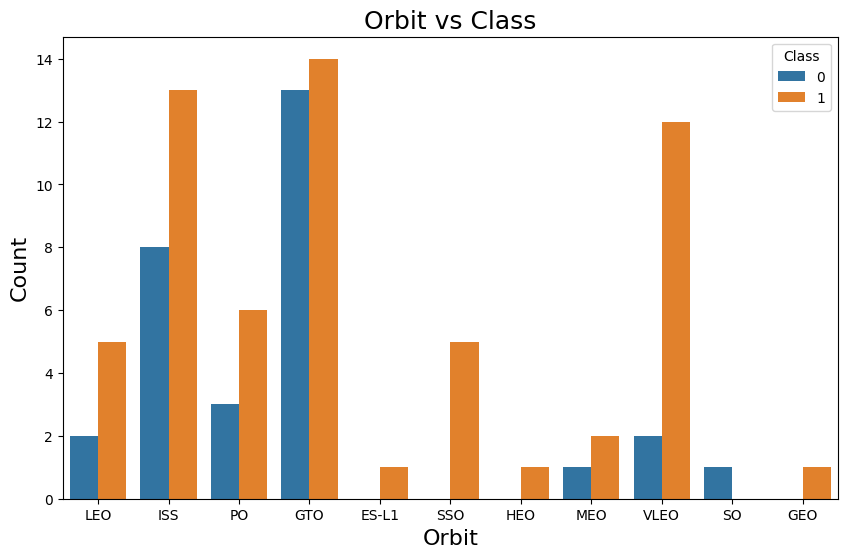

In [66]:
plt.figure(figsize=(10,6))
sns.countplot(x="Orbit", hue="Class", data=df)

plt.xlabel("Orbit", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Orbit vs Class", fontsize=18)
plt.show()


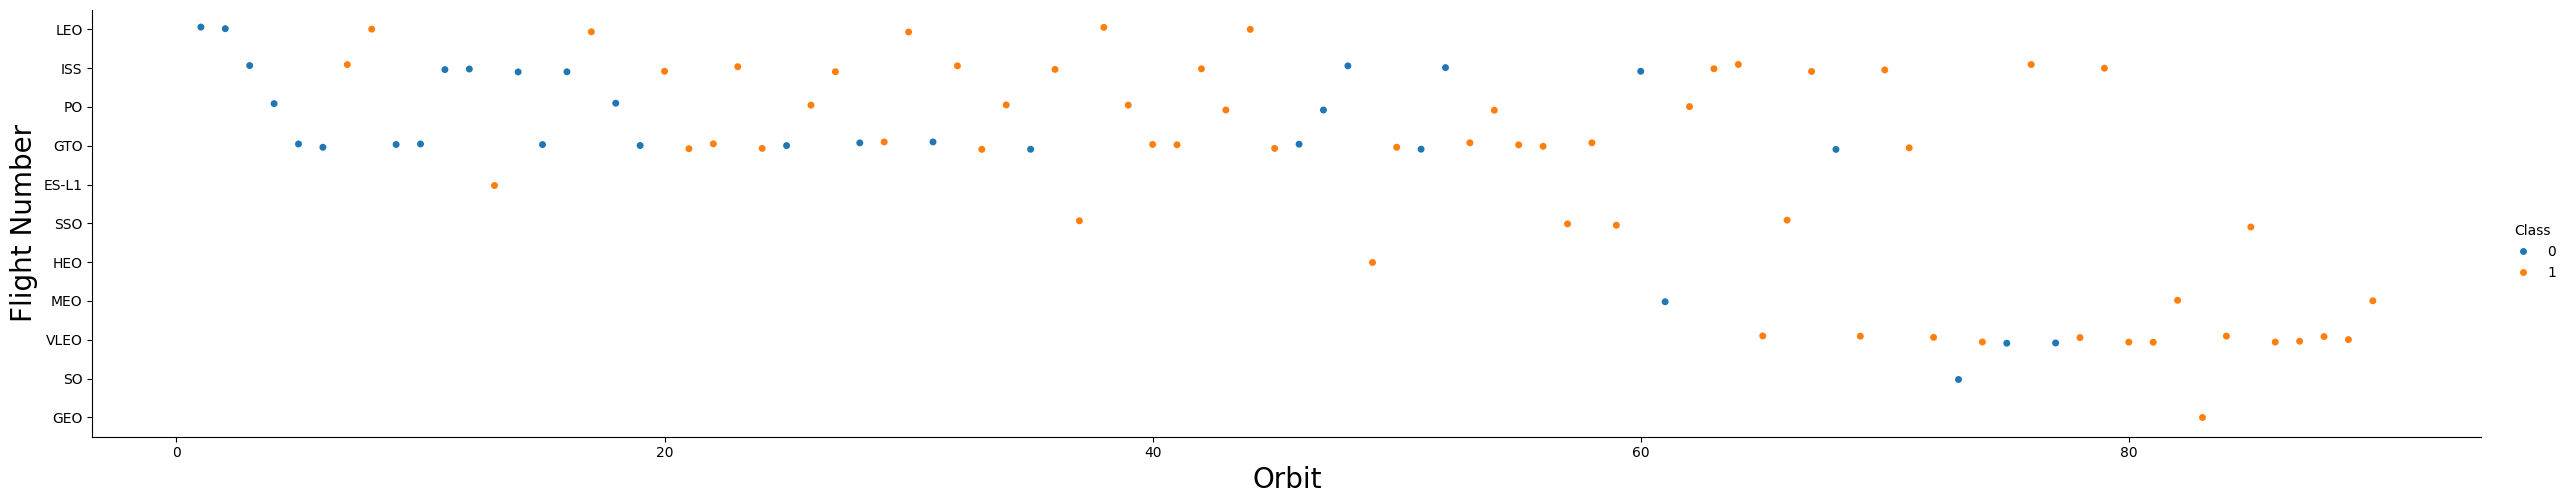

In [67]:
sns.catplot(y="Orbit", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.ylabel("Flight Number",fontsize=20)
plt.xlabel("Orbit",fontsize=20)
plt.show()

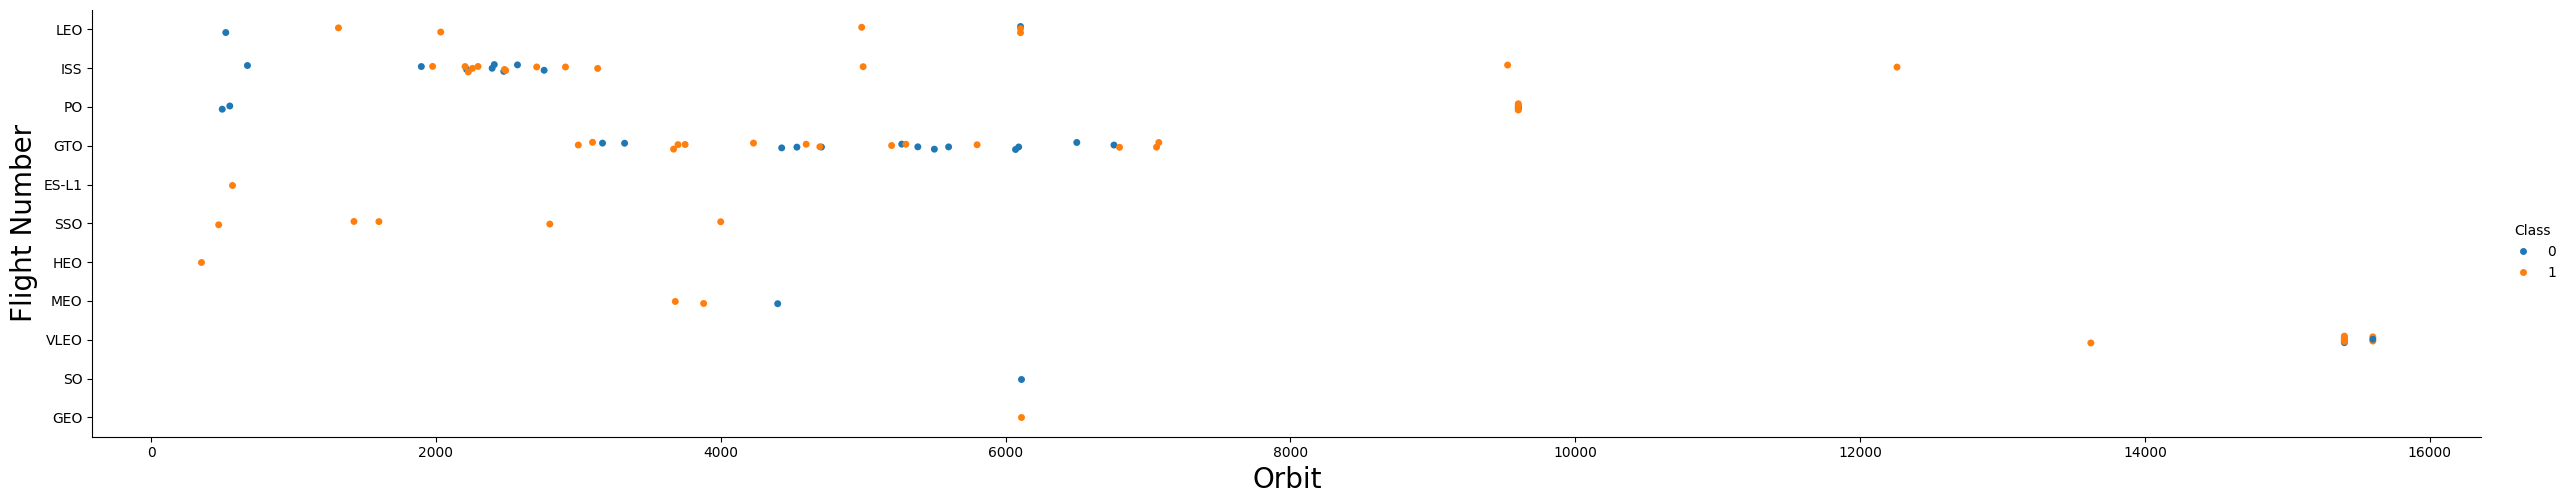

In [68]:
sns.catplot(y="Orbit", x="PayloadMass", hue="Class", data=df, aspect = 5)
plt.ylabel("Flight Number",fontsize=20)
plt.xlabel("Orbit",fontsize=20)
plt.show()

In [69]:
# A function to Extract years from the date
year=[]
def Extract_year():
    for i in df["Date"]:
        year.append(i.split("-")[0])
    return year
Extract_year()
df['Date'] = year
df.head()


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [70]:
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,6104.959412,LEO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0003
1,2,525.000000,LEO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0005
2,3,677.000000,ISS,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0007
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NaN,1.0,0,B1003
4,5,3170.000000,GTO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B1004


In [71]:
get_dummies = pd.get_dummies(data=features, columns=['Orbit', 'LaunchSite', 'LandingPad','Serial'])
get_dummies.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCAFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1,6104.959412,1,False,False,False,1.0,0,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2,525.000000,1,False,False,False,1.0,0,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,3,677.000000,1,False,False,False,1.0,0,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,4,500.000000,1,False,False,False,1.0,0,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,5,3170.000000,1,False,False,False,1.0,0,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [72]:
print(get_dummies.shape)
len(get_dummies)

(90, 80)


90

# Lab5

In [73]:
URL = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv'
df = pd.read_csv(URL)

In [74]:
df.columns

Index(['Flight Number', 'Date', 'Time (UTC)', 'Booster Version', 'Launch Site',
       'Payload', 'Payload Mass (kg)', 'Orbit', 'Customer', 'Landing Outcome',
       'class', 'Lat', 'Long'],
      dtype='object')

In [75]:
latitudes = df['Lat']
longitudes = df['Long']

In [76]:
m = folium.Map(location=[latitudes[0], longitudes[0]], zoom_start=5)

for lat, lon in zip(latitudes, longitudes):
    folium.Marker([lat, lon]).add_to(m)

In [77]:
m

In [78]:
print(latitudes.value_counts())
print(longitudes.value_counts())

Lat
28.562302    26
28.573255    13
34.632834    10
28.563197     7
Name: count, dtype: int64
Long
-80.577356     26
-80.646895     13
-120.610745    10
-80.576820      7
Name: count, dtype: int64


In [79]:
df = df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = df.groupby(['Launch Site'], as_index=False).first()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long']]
launch_sites_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


In [80]:
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)
site_map

In [81]:
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
marker = folium.map.Marker(
    nasa_coordinate,
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC',
        )
    )
site_map.add_child(circle)
site_map.add_child(marker)

In [82]:
site_map = folium.Map(location=nasa_coordinate, zoom_start=5)
site_map

# Lab6

In [83]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])
    plt.show()

In [84]:
URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
data = pd.read_csv(URL1)
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [85]:
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
data2 = pd.read_csv(URL2)
data2.head()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCAFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [86]:
Class = data['Class']
Class = Class.to_numpy()
Y =  pd.DataFrame(Class)
Y

,0
0,0
1,0
2,0
3,0
4,0
...,...
85,1
86,1
87,1
88,1


In [87]:
X = data2
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [88]:
X

array([[-1.71291154e+00, -1.94814463e-16, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       [-1.67441914e+00, -1.19523159e+00, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       [-1.63592675e+00, -1.16267307e+00, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       ...,
       [ 1.63592675e+00,  1.99100483e+00,  3.49060516e+00, ...,
         1.19684269e+00, -5.17306132e-01,  5.17306132e-01],
       [ 1.67441914e+00,  1.99100483e+00,  1.00389436e+00, ...,
         1.19684269e+00, -5.17306132e-01,  5.17306132e-01],
       [ 1.71291154e+00, -5.19213966e-01, -6.53912840e-01, ...,
        -8.35531692e-01, -5.17306132e-01,  5.17306132e-01]])

In [89]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [90]:
len(Y_test)

18

In [91]:
logreg = LogisticRegression(max_iter=10000)  # max_iter high to ensure convergence

parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

logreg_cv = GridSearchCV(logreg, parameters, cv=10, scoring='accuracy')
logreg_cv.fit(X_train, Y_train)


print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

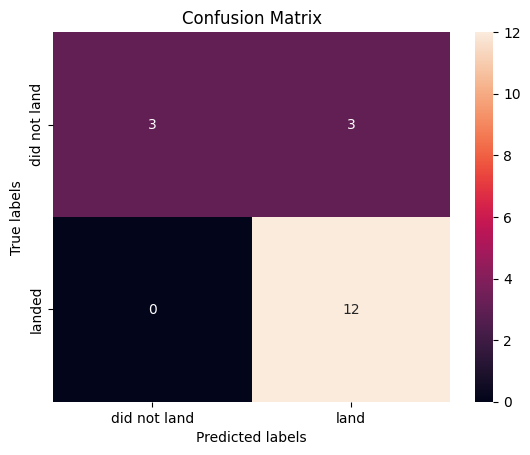

In [92]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [93]:
y_pred = logreg_cv.predict(X_test)
print("Test set accuracy:", accuracy_score(Y_test, y_pred))

Test set accuracy: 0.8333333333333334


In [94]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [95]:
svm_cv = GridSearchCV(svm, parameters, cv=10, scoring='accuracy')
svm_cv.fit(X_train, Y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')},
             scoring='accuracy')

In [96]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': np.float64(1.0), 'gamma': np.float64(0.03162277660168379), 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


In [97]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [98]:
tree_cv = GridSearchCV(tree, parameters, cv=10, scoring='accuracy')

tree_cv.fit(X_train, Y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/u

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             scoring='accuracy')

In [99]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.875


In [100]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

knn_cv = GridSearchCV(KNN, parameters, cv=10, scoring='accuracy')

knn_cv.fit(X_train, Y_train)

print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

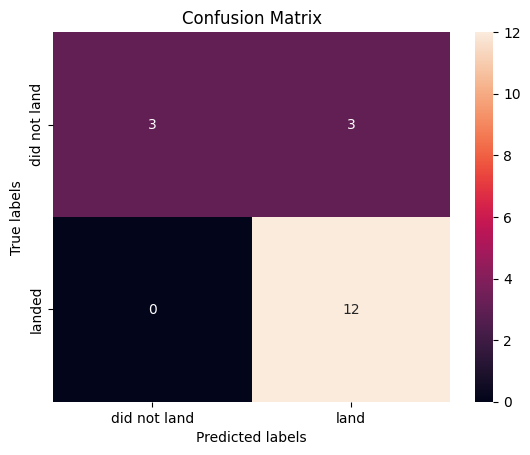

In [101]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)